In [248]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from a4_utils import *

def simple_convolution(signal, kernel):
    N = int(len(kernel) / 2) # kernel of size 2N + 1
    returnSignal = np.zeros(len(signal))
    for i in range(0, len(signal)): # loop through signal
        for j in range(0, 2*N+1): # loop through kenel
            index = i-(j-N)
            if index < 0: # extending edge
                index = 0
            elif index > len(signal)-1:
                index = len(signal)-1
            returnSignal[i] += kernel[j]*signal[index] # weigted sum

    return returnSignal

    
def gauss(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    for x in range(-N, N):
        kernel[x+N] = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-x**2 / (2 * (sigma**2)))

    return kernel / np.sum(kernel)

def gaussdx(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    sumOfAbs = 0
    for x in range(-N, N):
        v = -1 / (np.sqrt(2 * np.pi) * sigma**3) * x * np.exp(-x**2 / (2 * (sigma**2)))
        kernel[x+N] = v
        sumOfAbs += np.abs(v)

    return kernel / sumOfAbs

def partialDerivative(img, sigma):
    gaussKenrnel = gauss(sigma)
    dxGaussKernel = gaussdx(sigma)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, dxGaussKernel)
    return img

def getDerivatives(img, sigma):
    Ix = partialDerivative(np.copy(img), sigma)
    Iy = partialDerivative(np.copy(img.T), sigma).T
    Ixx = partialDerivative(np.copy(Ix), sigma)
    Iyy = partialDerivative(np.copy(Iy.T), sigma).T
    Ixy = partialDerivative(np.copy(Ix.T), sigma).T
    return Ix,Iy,Ixx,Iyy,Ixy

def gradient_magnitude(img):
    Ix, Iy, Ixx, Iyy, Ixy = getDerivatives(img, 1)
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    angle = np.arctan2(Ix,Iy)
    return magnitude, angle

def non_maxima_suppression(det, hw):
    arr = np.copy(det)
    for y, row in enumerate(arr):
        for x, pixel in enumerate(row):
            if x < hw or y < hw or x >= len(row) - hw or y >= len(arr) - hw:
                arr[y, x] = 0
                continue
            if(det[y,x] < np.max(det[(y-hw):(y+hw+1),(x-hw):(x+hw+1)])):
                arr[y,x] = 0
    return arr

def hessian_points(Ixx, Iyy, Ixy, threshold):
    det = Ixx * Iyy - Ixy * Ixy
    nnmsDet = non_maxima_suppression(det, 8)
    nnmsDet[nnmsDet <= threshold] = 0.0
    return det, nnmsDet

def gaussFilter(img, sigma):
    gaussKenrnel = gauss(sigma)
    img = np.copy(img.T)
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    return img

def auto_correlation_matrix(Ix, Iy, sigma):
    C11 = gaussFilter(Ix*Ix, sigma)
    C12 = gaussFilter(Ix*Iy, sigma)
    C21 = C12
    C22 = gaussFilter(Iy*Iy, sigma)
    return C11, C12, C21, C22

def herris_points(C11, C12, C21, C22, alpha, threshold):
    detC = C11*C22-C12*C21
    traceC = C11+C22
    arr = detC-alpha*traceC*traceC
    arr[arr <= threshold] = 0
    nnmsArr = non_maxima_suppression(arr, 10)
    return arr, nnmsArr

def hellingerDistance(arr, arr2):
    return np.sqrt(0.5 * np.sum((np.sqrt(arr) - np.sqrt(arr2)) ** 2))

def find_correspondences(d1, d2):
    arr = np.zeros(len(d1), dtype=int)
    for i, d in enumerate(d1):
        j = np.argmin(np.array(list(map(lambda a : hellingerDistance(d, a), d2)))) # gets index of minimum of distances from d in list1 to every a in list2
        arr[i] = j
    return arr

def find_matches(img, img2):
    Ix, Iy, Ixx, Iyy, Ixy = getDerivatives(img, 3)
    Ix2, Iy2, Ixx2, Iyy2, Ixy2 = getDerivatives(img2, 3)
    # det, nnmsDet = hessian_points(Ixx, Iyy, Ixy, 0.002)
    # det2, nnmsDet2 = hessian_points(Ixx2, Iyy2, Ixy2, 0.002)
    det, nnmsDet = hessian_points(Ixx, Iyy, Ixy, 0.002)
    det2, nnmsDet2 = hessian_points(Ixx2, Iyy2, Ixy2, 0.002)
    points = np.nonzero(nnmsDet)
    points2 = np.nonzero(nnmsDet2)
    descriptors = simple_descriptors(img, points[0], points[1])
    descriptors2 = simple_descriptors(img2, points2[0], points2[1])
    indexes = find_correspondences(descriptors, descriptors2)
    indexes2 = find_correspondences(descriptors2, descriptors)
    ijIndexes = np.array([range(0,len(indexes)), indexes]).T
    ijIndexes2 = np.array([indexes2, range(0,len(indexes2))]).T

    simmetricij = np.array([], dtype=int)
    for ij in ijIndexes:
        for ij2 in ijIndexes2:
            if (ij == ij2).all():
                simmetricij = np.append(simmetricij, ij, 0)

    simmetricij = np.reshape(simmetricij, (int(len(simmetricij)/2), 2))
    return points, points2, simmetricij


# Exercise 3

Question: Looking at the equation above, which parameters account for translation
and which for rotation and scale?

Answer: p3,p4...translation; p1,p2...rotation,scale

### a

[[ 21.  96.  64.  52.]
 [246.  94. 238. 195.]
 [ 25. 185.  10. 122.]
 [186. 207. 121. 243.]]


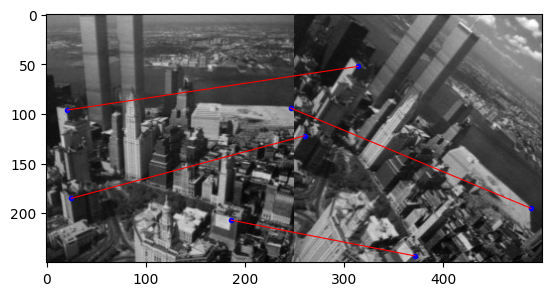

In [128]:
temp = cv2.imread('data/newyork/newyork_a.jpg') # 0-255
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
temp = temp.astype(np.float64) / 255
temp2 = cv2.imread('data/newyork/newyork_b.jpg') # 0-255
temp2 = cv2.cvtColor(temp2, cv2.COLOR_BGR2GRAY)
temp2 = temp2.astype(np.float64) / 255
data = np.loadtxt("data/newyork/newyork.txt")
print(data)
display_matches(temp, data[:,0:2], temp2, data[:,2:4])

In [129]:
# constructing A
def estimate_homography(data):
    A = np.array([])
    for d in data:
        A = np.append(A, [d[0], d[1], 1, 0, 0, 0, -d[2]*d[0], -d[2]*d[1], -d[2]], 0)
        A = np.append(A, [0, 0, 0, d[0], d[1], 1, -d[3]*d[0], -d[3]*d[1], -d[3]], 0)
    A = np.reshape(A, (int(len(data)*2), 9))
    U, S, VT = np.linalg.svd(A)
    H = np.reshape(VT.T[:, 8] / VT.T[8, 8], (3,3))
    return H

[[ 7.68066321e-01 -6.37561940e-01  1.08599883e+02]
 [ 6.42462642e-01  7.41785866e-01 -3.30904536e+01]
 [ 2.51437379e-05 -8.30833330e-05  1.00000000e+00]]


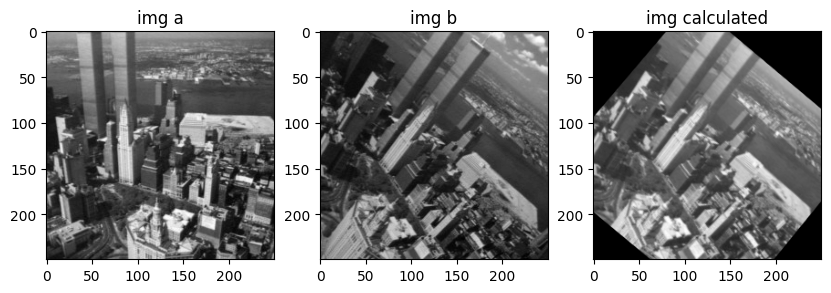

In [130]:
H = estimate_homography(data)
print(H)
temp3 = np.zeros(temp.shape)
temp3 = cv2.warpPerspective(temp, H, temp.shape)

f = plt.figure(figsize=(10, 10))
f.add_subplot(1, 3, 1)
plt.imshow(temp, cmap="gray")
plt.title("img a")
f.add_subplot(1, 3, 2)
plt.imshow(temp2, cmap="gray")
plt.title("img b")
f.add_subplot(1, 3, 3)
plt.imshow(temp3, cmap="gray")
plt.title("img calculated")
plt.show()

[[251. 275. 342. 270.]
 [539. 309. 573. 314.]
 [140. 517. 239. 527.]
 [469. 454. 524. 446.]]


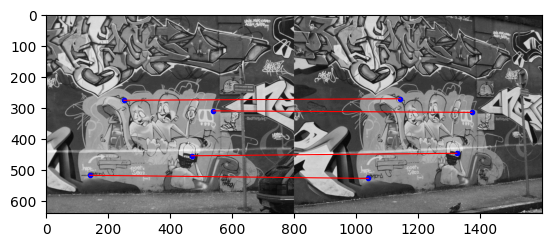

[[ 1.27437554e+00  3.43710625e-02  6.81319745e+01]
 [ 2.23945482e-01  1.21445700e+00 -7.64078762e+01]
 [ 5.99335420e-04  4.25744503e-05  1.00000000e+00]]


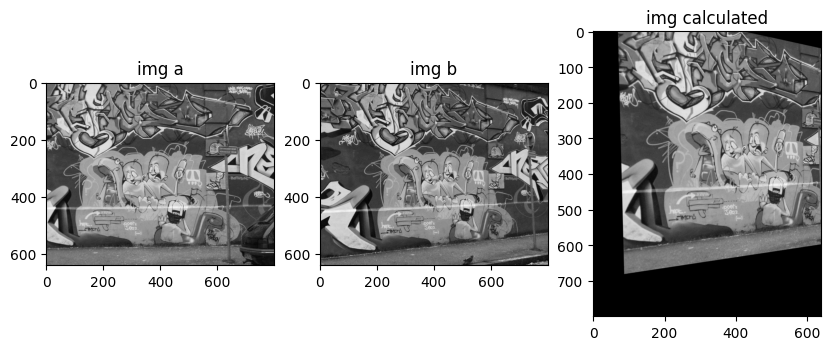

In [131]:
temp = cv2.imread('data/graf/graf_a.jpg') # 0-255
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
temp = temp.astype(np.float64) / 255
temp2 = cv2.imread('data/graf/graf_b.jpg') # 0-255
temp2 = cv2.cvtColor(temp2, cv2.COLOR_BGR2GRAY)
temp2 = temp2.astype(np.float64) / 255

data = np.loadtxt("data/graf/graf.txt")
print(data)
display_matches(temp, data[:,0:2], temp2, data[:,2:4])
H = estimate_homography(data)
print(H)
temp3 = np.zeros(temp.shape)
temp3 = cv2.warpPerspective(temp, H, temp.shape, temp3)

f = plt.figure(figsize=(10, 10))
f.add_subplot(1, 3, 1)
plt.imshow(temp, cmap="gray")
plt.title("img a")
f.add_subplot(1, 3, 2)
plt.imshow(temp2, cmap="gray")
plt.title("img b")
f.add_subplot(1, 3, 3)
plt.imshow(temp3, cmap="gray")
plt.title("img calculated")
plt.show()

### b

In [274]:
temp = cv2.imread('data/newyork/newyork_a.jpg') # 0-255
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
temp = temp.astype(np.float64) / 255
temp2 = cv2.imread('data/newyork/newyork_b.jpg') # 0-255
temp2 = cv2.cvtColor(temp2, cv2.COLOR_BGR2GRAY)
temp2 = temp2.astype(np.float64) / 255

# temp = cv2.imread('data/graf/graf_a.jpg') # 0-255
# temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
# temp = temp.astype(np.float64) / 255
# temp2 = cv2.imread('data/graf/graf_b.jpg') # 0-255
# temp2 = cv2.cvtColor(temp2, cv2.COLOR_BGR2GRAY)
# temp2 = temp2.astype(np.float64) / 255


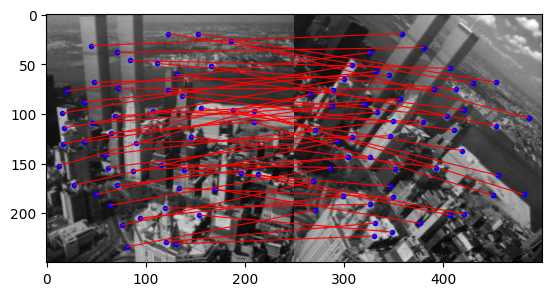

In [275]:
bPoints, bPoints2, simmetricij = find_matches(temp, temp2)
# points[1]...x, points[0]...y
p = np.array([bPoints[1], bPoints[0]]).T[simmetricij[:,0]]
pp = np.array([bPoints2[1], bPoints2[0]]).T[simmetricij[:,1]]
display_matches(temp, p, temp2, pp)

In [276]:
def ransac(data, k, inlierDistance, minPercentageOfInliers):
    homogeniousFirstImagePoints = np.concatenate([data[:, 0:2].T, np.ones((1, len(data)))])
    minDist = None
    H = np.array([[1,0,0],[0,1,0],[0,0,1]], dtype=float)
    
    for i in range(k):
        randomPointIndexes = np.zeros(4)
        while(len(np.unique(randomPointIndexes)) < 4):
            randomPointIndexes = np.random.randint(0, len(data), size=4)

        newH = estimate_homography(data[randomPointIndexes])
        homogeniousSecondImagePoints = np.matmul(newH, homogeniousFirstImagePoints)
        homogeniousSecondImagePoints = homogeniousSecondImagePoints / homogeniousSecondImagePoints[2, :]

        distances = (homogeniousSecondImagePoints[0, :].T - data[:,2])**2 + (homogeniousSecondImagePoints[1, :].T - data[:,3])**2
        inliers = data[distances < inlierDistance]
        if len(inliers) / len(data) > minPercentageOfInliers:
            newH = estimate_homography(inliers)
            homogeniousSecondImagePoints = np.matmul(newH, homogeniousFirstImagePoints)
            homogeniousSecondImagePoints = homogeniousSecondImagePoints / homogeniousSecondImagePoints[2, :]
            distances = (homogeniousSecondImagePoints[0, :].T - data[:,2])**2 + (homogeniousSecondImagePoints[1, :].T - data[:,3])**2
            distance = np.sum(distances)
            if minDist is None or distance < minDist:
                minDist = distance
                bestInliersPoints = inliers
                H = newH
    return H


data = np.array([p[:,0],p[:,1],pp[:,0],pp[:,1]]).T
H = ransac(data, 1000, 50, 0.5)
# print(H)

temp3 = np.zeros(temp.shape)
temp3 = cv2.warpPerspective(temp, H, temp.shape, temp3)

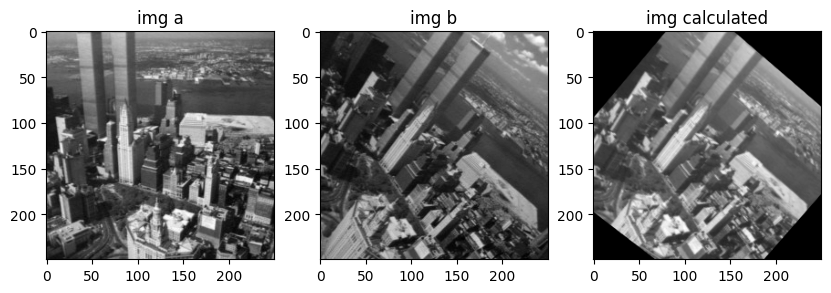

In [277]:
f = plt.figure(figsize=(10, 10))
f.add_subplot(1, 3, 1)
plt.imshow(temp, cmap="gray")
plt.title("img a")
f.add_subplot(1, 3, 2)
plt.imshow(temp2, cmap="gray")
plt.title("img b")
f.add_subplot(1, 3, 3)
plt.imshow(temp3, cmap="gray")
plt.title("img calculated")
plt.show()